# Get Data and Model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


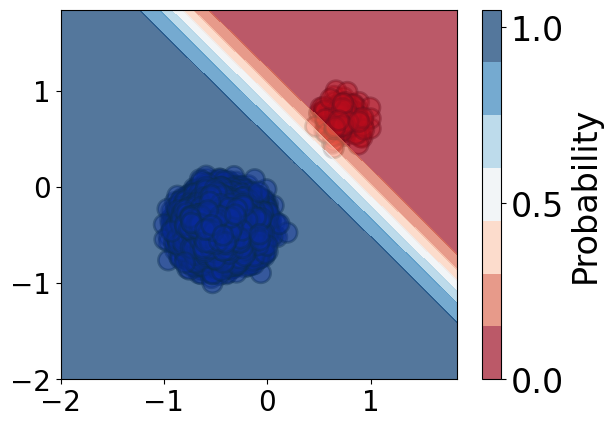

  0%|          | 0/10000 [00:00<?, ?it/s]/home/matt/projects/linear_confidence/deltas.py:38: RuntimeWarning: divide by zero encountered in divide
  ((1/(N1*delta1)) * (1/(np.sqrt((2*np.log(1/delta1))/N1))))
100%|██████████| 10000/10000 [00:12<00:00, 779.45it/s]


Text(0.5, 1.0, 'solve deltas same data with number of runs 10000')

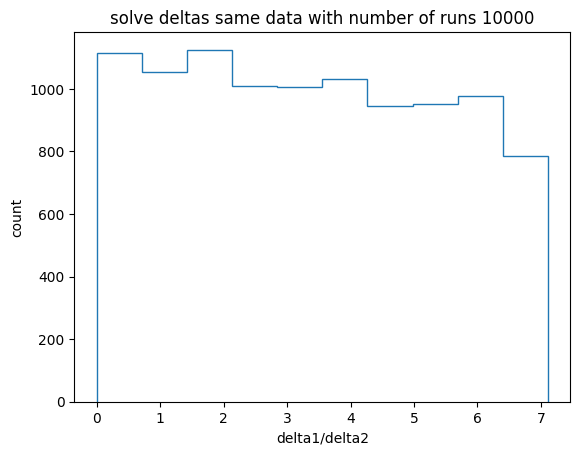

In [33]:
%load_ext autoreload
%autoreload 2

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.optimize import minimize
from tqdm import tqdm
import matplotlib.pyplot as plt

import data_utils
import plots
import truncated_normal, normal
import deltas
import projection
import radius

m1 = [1, 1]
m2 = [10, 10]

cov1 = [[1, 0], [0, 1]]
cov2 = [[5, 0], [0, 5]]
cov2 = cov1

N1 = 10000
N2 = 100
scale = True

data = normal.get_two_classes(means=[m1, m2], 
                              covs=[cov1, cov2],
                              num_samples=[N1, N2])
scaler = data_utils.normaliser(data)
if scale == True:
    data = scaler(data)
    m1 = scaler.transform_instance(m1)
    m2 = scaler.transform_instance(m2)

clf = SVC(random_state=0, probability=True,
          kernel='linear').fit(data['X'], data['y'])

clf = LogisticRegression().fit(data['X'], data['y'])

ax, _ = plots._get_axes(None)
plots.plot_classes(data, ax=ax)
plots.plot_decision_boundary(clf, data, ax=ax)
plots.plt.show()

# get projections
proj_data = projection.from_clf(data, clf, supports=True)
proj_means = projection.from_clf({'X': np.array([m1, m2]), 'y': [0, 1]}, clf)

# Empircal M
M_emp = np.abs(proj_data['supports'][1]-proj_data['supports'][0]).squeeze()

# get Rs
R_sup = radius.supremum(data['X'])
R_sup = radius.supremum(proj_data['X'])
# empirical means
xp1, xp2 = projection.get_classes(proj_data)
emp_xp1, emp_xp2 = projection.get_emp_means(proj_data)
R1_emp = radius.supremum(proj_data['X1'], emp_xp1)
R2_emp = radius.supremum(proj_data['X2'], emp_xp2)

# Optimise Eq. 6 using the constraint eq. 9
c1 = 1
c2 = 1

def optimise_deltas(N1, N2, M_emp, R_sup, c1=1, c2=1):
    bounds = [(0, 1)]
    delta1_init = (0.5)
    delta1_init = (np.random.uniform())

    use_grad = True
    if use_grad == True:
        func = deltas.scipy_optim_func
    else:
        func = deltas.loss_one_delta
    res = minimize(func,
                delta1_init,
                (c1, c2, N1, N2, M_emp, R_sup), 
                # method='CG', 
                bounds=bounds,
                jac=use_grad,  # use gradient
                )
    delta1 = res.x
    delta2 = deltas.delta2_given_delta1(N1, N2, M_emp, delta1, R_sup)
    return delta1[0], delta2[0]

num_runs = 10000
results = []
for i in tqdm(range(num_runs)):
    delta1, delta2 = optimise_deltas(N1, N2, M_emp, R_sup, c1=1, c2=1)
    results.append(delta1/delta2)

counts, bins = np.histogram(results)
plt.stairs(counts, bins)
plt.xlabel('delta1/delta2')
plt.ylabel('count')
plt.title(f'solve deltas same data with number of runs {num_runs}')